# Camera Calibration

In [1]:
# # # UNIX-based system
# base_path = "d:\\VIBOT Master\\Semester 2\\Computer Vision\\Practicals\\Stereo\\stereo_reconstruction_cv"

# LINUX-based system
base_path = "/home/rafay/Documents/rafay/Educational/Vibot/M1/CV_fofi/cv_project_yohan/stereo_reconstruction_cv"
dataset_name = "dataset/d8"
calib_data_name = "calibration_data_logitech_1280x720"
lowe_ration = 0.75  # for filtering feature matches

In [2]:
import numpy as np
import cv2
import glob
import argparse
import os
import matplotlib.pyplot as plt
import open3d as o3d


class StereoCalibration(object):
    def __init__(self, filepath):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            100,
            1e-5,
        )

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9 * 7, 3), np.float32)
        self.objp[:, :2] = np.mgrid[0:9, 0:7].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        checkerboardsize = (9, 7)
        images = glob.glob(cal_path + "/*.jpg")
        images_right = sorted([os.path.join(cal_path, img_path) for img_path in images])
        images_left = sorted([os.path.join(cal_path, img_path) for img_path in images])

        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(
                gray_l,
                checkerboardsize,
                cv2.CALIB_CB_ADAPTIVE_THRESH
                + cv2.CALIB_CB_FAST_CHECK
                + cv2.CALIB_CB_NORMALIZE_IMAGE,
            )
            ret_r, corners_r = cv2.findChessboardCorners(
                gray_r,
                checkerboardsize,
                cv2.CALIB_CB_ADAPTIVE_THRESH
                + cv2.CALIB_CB_FAST_CHECK
                + cv2.CALIB_CB_NORMALIZE_IMAGE,
            )

            # If found, add object points, image points (after refining them)
            self.objpoints.append(self.objp)

            if ret_l is True:
                rt = cv2.cornerSubPix(
                    gray_l, corners_l, (11, 11), (-1, -1), self.criteria
                )
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                ret_l = cv2.drawChessboardCorners(
                    img_l, checkerboardsize, corners_l, ret_l
                )

            if ret_r is True:
                rt = cv2.cornerSubPix(
                    gray_r, corners_r, (11, 11), (-1, -1), self.criteria
                )
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                ret_r = cv2.drawChessboardCorners(
                    img_r, checkerboardsize, corners_r, ret_r
                )
        img_shape = gray_l.shape[::-1]

        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_l, img_shape, None, None
        )
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(
            self.objpoints, self.imgpoints_r, img_shape, None, None
        )

        self.camera_model = self.stereo_calibrate(img_shape)

    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        flags |= cv2.CALIB_ZERO_TANGENT_DIST

        stereocalib_criteria = (
            cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            100,
            1e-5,
        )
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints,
            self.imgpoints_l,
            self.imgpoints_r,
            self.M1,
            self.d1,
            self.M2,
            self.d2,
            dims,
            criteria=stereocalib_criteria,
            flags=flags,
        )

        print("Intrinsic_mtx_1", M1)
        print("dist_1", d1)
        print("Intrinsic_mtx_2", M2)
        print("dist_2", d2)
        print("R", R)
        print("T", T)
        print("E", E)
        print("F", F)
        camera_model = dict(
            [
                ("M1", M1),
                ("M2", M2),
                ("dist1", d1),
                ("dist2", d2),
                ("rvecs1", self.r1),
                ("rvecs2", self.r2),
                ("R", R),
                ("T", T),
                ("E", E),
                ("F", F),
                ("image_size", dims),
            ]
        )

        return camera_model

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
cal_data = StereoCalibration(os.path.join(base_path, calib_data_name))

K0 = np.array(cal_data.camera_model["M1"])
K1 = np.array(cal_data.camera_model["M1"])
dist_coeffs0 = np.array(cal_data.camera_model["dist1"])
dist_coeffs1 = np.array(cal_data.camera_model["dist2"])
R = np.array(cal_data.camera_model["R"])
T = np.array(cal_data.camera_model["T"])
F = np.array(cal_data.camera_model["F"])
E = np.array(cal_data.camera_model["E"])
image_size = np.array(cal_data.camera_model["image_size"])

Intrinsic_mtx_1 [[1.49491610e+03 0.00000000e+00 6.51338571e+02]
 [0.00000000e+00 1.48784232e+03 4.40753670e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_1 [[ 0.28743235 -0.2783191   0.03948179  0.00182591  0.64196279]]
Intrinsic_mtx_2 [[1.49491610e+03 0.00000000e+00 6.51338571e+02]
 [0.00000000e+00 1.48784232e+03 4.40753670e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_2 [[ 0.28743235 -0.2783191   0.03948179  0.00182591  0.64196279]]
R [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
T [[-2.22044605e-15]
 [-4.44089210e-16]
 [ 4.75603231e-27]]
E [[ 0.00000000e+00 -4.75603231e-27 -4.44089210e-16]
 [ 4.75603231e-27  0.00000000e+00  2.22044605e-15]
 [ 4.44089210e-16 -2.22044605e-15  0.00000000e+00]]
F [[ 0.00000000e+00 -2.13831198e-33 -2.97066310e-19]
 [ 2.13831198e-33  0.00000000e+00  1.49239339e-18]
 [ 2.97066310e-19 -1.49239339e-18  0.00000000e+00]]


# Rectification

In [4]:
def stereo_rectify(K0, K1, R, T, image_size):
    """Performs stereo rectification.

    This function takes the camera intrinsic parameters (K0, K1), rotation (R),
    translation (T) between the two cameras, and the image size, and returns
    the rectification transformations (R1, R2, P1, P2) and the disparity-to-depth
    mapping matrix (Q).  It uses OpenCV's stereoRectify function.

    Args:
        K0: Camera intrinsic matrix for the left camera (3x3 numpy array).
        K1: Camera intrinsic matrix for the right camera (3x3 numpy array).
        R: Rotation matrix between the two cameras (3x3 numpy array).
        T: Translation vector between the two cameras (3x1 or 1x3 numpy array).
        image_size: Size of the image (tuple or list of (width, height)).

    Returns:
        R1: Rectification rotation matrix for the left camera (3x3 numpy array).
        R2: Rectification rotation matrix for the right camera (3x3 numpy array).
        P1: Projection matrix for the left camera after rectification (3x4 numpy array).
        P2: Projection matrix for the right camera after rectification (3x4 numpy array).
        Q: Disparity-to-depth mapping matrix (4x4 numpy array).
    """
    T = T.astype(np.float64)  # Ensure T is float64 for cv2.stereoRectify

    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        K0, None, K1, None, image_size, R, T, alpha=1, flags=cv2.CALIB_CB_ACCURACY
    )
    return R1, R2, P1, P2, Q

In [16]:
# Perform stereo rectification
R1, R2, P1, P2, Q = stereo_rectify(K0, K1, R, T, image_size)

# Print results for verification
print("R1:\n", R1)
print("R2:\n", R2)
print("P1:\n", P1)
print("P2:\n", P2)
print("Q:\n", Q)

R1:
 [[ 9.80580676e-01  1.96116135e-01 -2.10033177e-12]
 [-1.96116135e-01  9.80580676e-01  2.07973830e-13]
 [ 2.10033177e-12  2.07973830e-13  1.00000000e+00]]
R2:
 [[ 9.80580676e-01  1.96116135e-01 -2.10033177e-12]
 [-1.96116135e-01  9.80580676e-01  2.07973830e-13]
 [ 2.10033177e-12  2.07973830e-13  1.00000000e+00]]
P1:
 [[1.04949241e+03 0.00000000e+00 6.66988876e+02 0.00000000e+00]
 [0.00000000e+00 1.04949241e+03 4.36865036e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
P2:
 [[ 1.04949241e+03  0.00000000e+00  6.66988876e+02 -2.37649114e-12]
 [ 0.00000000e+00  1.04949241e+03  4.36865036e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
Q:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -6.66988876e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.36865036e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.04949241e+03]
 [ 0.00000000e+00  0.00000000e+00  4.41614277e+14 -0.00000000e+00]]


In [38]:
# Example usage (replace with your actual paths)
left_image = os.path.join(dataset_name, "img1.jpg")
right_image = os.path.join(dataset_name, "img2.jpg")

# Read Images
imgL = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)
imgL_color = cv2.imread(left_image)  # For color visualization


# Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_32F)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_32F)

imgL_rect = cv2.remap(imgL, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)

In [39]:
def draw_epilines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),10,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),10,color,-1)
    return img1,img2


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Text(0.5, 1.0, 'Disparity Map (SGBM)')

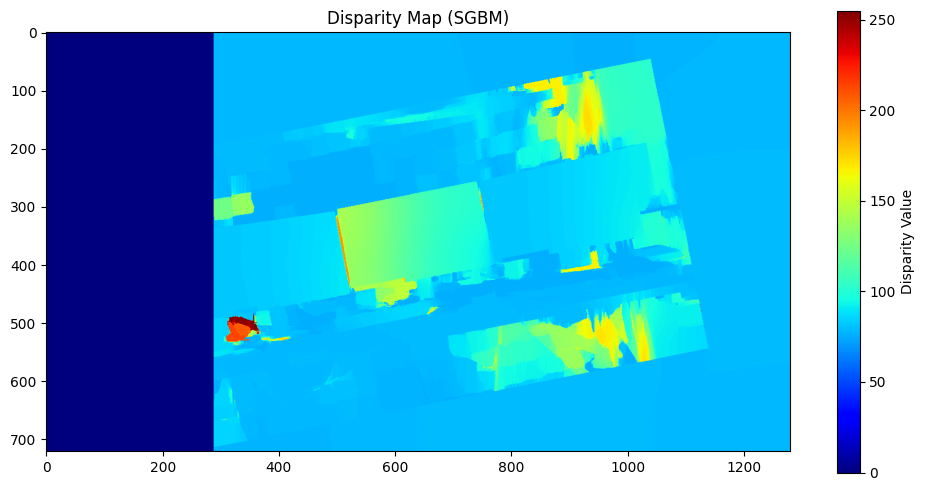

In [40]:
!pip3 install opencv-contrib-python
def compute_disparity_sgbm(imgL, imgR):
    """
    Computes the disparity map using Semi-Global Block Matching (SGBM).
    :param imgL: Left stereo image (grayscale)
    :param imgR: Right stereo image (grayscale)
    :return: Computed disparity map (normalized)
    """
    numdisparities = ((270 // 16) + 1) * 16  # Ensure numDisparities is a multiple of 16

    # Create a StereoSGBM object with tuned parameters
    stereo = cv2.StereoSGBM_create(
        minDisparity=16,  # Minimum possible disparity
        numDisparities=numdisparities,  # Maximum disparity range (must be multiple of 16)
        blockSize=13,  # Size of block matching window
        P1=8 * 3 * 10**2,  # Penalty for small disparity changes
        P2=32 * 3 * 10**2,  # Penalty for large disparity changes
        disp12MaxDiff=1,  # Max allowed difference in left-right disparity check
        uniquenessRatio=15,  # Ensures unique disparity values
        speckleWindowSize=200,  # Reduces noise in disparity map
        speckleRange=2,  # Limits disparity variation in small areas.
        preFilterCap=31,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )

    return stereo


stereo_left = compute_disparity_sgbm(imgL_rect, imgR_rect)  # Compute SGBM disparity map


stereo_right = cv2.ximgproc.createRightMatcher(stereo_left)  # Right matcher for WLS

# Compute disparity maps
disparity_left = stereo_left.compute(imgL_rect, imgR_rect).astype(np.float32) / 16.0
disparity_right = stereo_right.compute(imgR_rect, imgL_rect).astype(np.float32) / 16.0

# Create WLS filter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo_left)
wls_filter.setLambda(10000)  # Higher values smooth more
wls_filter.setSigmaColor(3)  # Edge-preserving filter

# Apply WLS filtering
filtered_disparity = wls_filter.filter(
    disparity_left, imgL_rect, disparity_map_right=disparity_right
)

# Normalize disparity for visualization
filtered_disparity_norm = cv2.normalize(
    filtered_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
)
filtered_disparity_norm = np.int16(filtered_disparity_norm)

# Display the computed disparity maps
plt.figure(figsize=(12, 6))  # Set figure size
# Plot SGBM disparity map
plt.subplot(1, 1, 1)
plt.imshow(filtered_disparity_norm, cmap="jet")  # Use plasma colormap for visualization
plt.colorbar(label="Disparity Value")  # Add color legend
plt.title("Disparity Map (SGBM)")  # Title for SGBM disparity map

In [41]:
def reconstruct_3D(disparity_map, Q):
    """
    Reconstructs a 3D point cloud from the disparity map using the reprojection matrix.

    :param disparity_map: The computed disparity map (output from StereoSGBM or StereoBM)
    :param Q: The reprojection matrix obtained from stereo rectification
    :return: A 3D point cloud where each pixel (x, y) has a corresponding 3D coordinate (X, Y, Z)
    """
    # Convert disparity map into a 3D point cloud
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

    return points_3D


# Example usage (assuming Q is already computed from stereo rectification)
# Placeholder for reprojection matrix; replace with actual Q from stereo rectification

# Reconstruct 3D points using the SGBM disparity map
points_3D_sgbm = reconstruct_3D(filtered_disparity_norm, Q)
print(points_3D_sgbm)  # Print raw 3D point cloud data

# Print the shape of the generated 3D point clouds for verification
print("3D Points (SGBM):", points_3D_sgbm.shape)  # Shape should match input image size

[[[          -inf           -inf            inf]
  [          -inf           -inf            inf]
  [          -inf           -inf            inf]
  ...
  [ 1.7709245e-14 -1.2682638e-14  3.0467836e-14]
  [ 1.7738276e-14 -1.2682638e-14  3.0467836e-14]
  [ 1.7767307e-14 -1.2682638e-14  3.0467836e-14]]

 [[          -inf           -inf            inf]
  [          -inf           -inf            inf]
  [          -inf           -inf            inf]
  ...
  [ 1.7709245e-14 -1.2653607e-14  3.0467836e-14]
  [ 1.7738276e-14 -1.2653607e-14  3.0467836e-14]
  [ 1.7767307e-14 -1.2653607e-14  3.0467836e-14]]

 [[          -inf           -inf            inf]
  [          -inf           -inf            inf]
  [          -inf           -inf            inf]
  ...
  [ 1.7709245e-14 -1.2624576e-14  3.0467836e-14]
  [ 1.7738276e-14 -1.2624576e-14  3.0467836e-14]
  [ 1.7767307e-14 -1.2624576e-14  3.0467836e-14]]

 ...

 [[          -inf            inf            inf]
  [          -inf            inf       

In [42]:
import open3d as o3d


def visualize_point_cloud(points_3D, colors, disparity_map):
    """
    Visualizes the 3D point cloud using Open3D.

    :param points_3D: 3D reconstructed points (X, Y, Z) from disparity map
    :param colors: Corresponding RGB colors for each point
    :param disparity_map: Disparity map used for filtering valid points
    """
    # Mask invalid points (where disparity is NaN, infinite, or non-positive)
    mask = (
        ~np.isnan(points_3D[:, :, 0])
        & ~np.isinf(points_3D[:, :, 0])
        & (disparity_map > 0)
    )  # Added disparity threshold

    # Extract valid points and corresponding colors
    valid_points = points_3D[mask]
    valid_colors = colors[mask]

    # Create Open3D point cloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(
        valid_points.reshape(-1, 3)
    )  # Reshape into Nx3 format
    point_cloud.colors = o3d.utility.Vector3dVector(
        valid_colors.reshape(-1, 3) / 255.0
    )  # Normalize colors (0 to 1)

    # Visualize point cloud using Open3D
    o3d.visualization.draw_geometries([point_cloud])


# Load color image for point cloud visualization
colors = cv2.imread(left_image)  # Read color image
colors = cv2.cvtColor(
    colors, cv2.COLOR_BGR2RGB
)  # Convert from BGR (OpenCV format) to RGB

# Visualize the reconstructed point cloud using SGBM disparity map
visualize_point_cloud(points_3D_sgbm, colors, filtered_disparity_norm)

In [123]:
## Tutorial : https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html

# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
 
# Filter matches using the Lowe's ratio test
pts_left = []
pts_right = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts_left.append(keypoints_left[m.queryIdx].pt)
        pts_right.append(keypoints_right[m.trainIdx].pt)


pts_left = np.int32(pts_left)
pts_right = np.int32(pts_right)
F, mask = cv2.findFundamentalMat(pts_left,pts_right,cv2.FM_LMEDS)

# We select only inlier points
pts_left = pts_left[mask.ravel()==1]
pts_right = pts_right[mask.ravel()==1]

# Compute the Essential Matrix
E, mask = cv2.findEssentialMat(pts_left, pts_right, K0, method=cv2.RANSAC, prob=0.999, threshold=1.0)
 
# Decompose the Essential Matrix to recover R and T
_, R, T, _ = cv2.recoverPose(E, pts_left, pts_right, K0)

print("Fundemental Matrix (F):\n", F) 
print("Relative Rotation (R):\n", R)
print("Relative Translation (T):\n", T)


Fundemental Matrix (F):
 [[-8.11483070e-09  1.58234535e-06 -1.95818093e-03]
 [-1.84403565e-06 -1.79451342e-06  3.63956535e-02]
 [ 2.32380603e-03 -3.29200997e-02  1.00000000e+00]]
Relative Rotation (R):
 [[ 0.99966962  0.00815702  0.02437438]
 [-0.00717787  0.99917421 -0.03999226]
 [-0.02468047  0.0398041   0.99890265]]
Relative Translation (T):
 [[ 0.99996741]
 [ 0.00640104]
 [-0.00492088]]


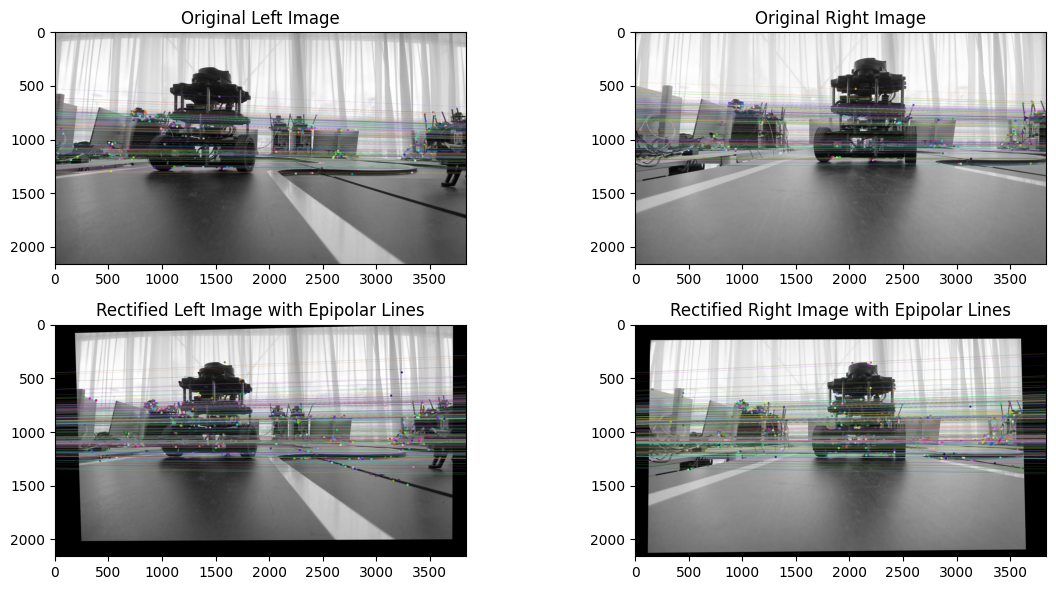

True

In [ ]:
## git gist : https://gist.github.com/jensenb/8668000

## Epilines before rectification

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_before_lines = cv2.computeCorrespondEpilines(pts_right.reshape(-1,1,2), 2,F)
left_before_lines = left_before_lines.reshape(-1,3)
imgL_before_rec,_ = draw_epilines(imgL,imgR,left_before_lines,pts_left,pts_right)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_before_lines = cv2.computeCorrespondEpilines(pts_left.reshape(-1,1,2), 1,F)
right_before_lines = right_before_lines.reshape(-1,3)
imgR_before_rec,_ = draw_epilines(imgR,imgL,right_before_lines,pts_right,pts_left)

# Stereo rectification using assumed R and T (no rotation, baseline translation)
R1, R2, P1, P2, Q = stereo_rectify(K0, K1, R, T, image_size)

# Rectify Images
mapL1, mapL2 = cv2.initUndistortRectifyMap(K0, None, R1, P1, image_size, cv2.CV_32F)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K1, None, R2, P2, image_size, cv2.CV_32F)

imgL_rect = cv2.remap(imgL, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)
imgR_rect = cv2.remap(imgR, mapR1, mapR2, interpolation=cv2.INTER_LINEAR)
imgL_rect_color = cv2.remap(imgL_color, mapL1, mapL2, interpolation=cv2.INTER_LINEAR)

## REDO everything now for the rectified pair 
# Use SIFT for feature detection and matching
sift = cv2.SIFT_create()
keypoints_left_rect, descriptors_left_rect = sift.detectAndCompute(imgL_rect, None)
keypoints_right_rect, descriptors_right_rect = sift.detectAndCompute(imgR_rect, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# Use FLANN-based matcher to find correspondences
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors_left_rect, descriptors_right_rect, k=2)

# Filter matches using the Lowe's ratio test
pts_left_rect = []
pts_right_rect = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts_left_rect.append(keypoints_left_rect[m.queryIdx].pt)
        pts_right_rect.append(keypoints_right_rect[m.trainIdx].pt)


pts_left_rect = np.int32(pts_left_rect)
pts_right_rect = np.int32(pts_right_rect)
F_rect, mask = cv2.findFundamentalMat(pts_left_rect,pts_right_rect,cv2.FM_LMEDS)

# We select only inlier points
pts_left_rect = pts_left_rect[mask.ravel()==1]
pts_right_rect = pts_right_rect[mask.ravel()==1]

# Draw epipolar lines on the rectified images

# Find epilines corresponding to points in right image and
# drawing its lines on left image
left_after_lines = cv2.computeCorrespondEpilines(pts_right_rect.reshape(-1,1,2), 2,F_rect)
left_after_lines = left_after_lines.reshape(-1,3)
imgL_after_rec,_ = draw_epilines(imgL_rect,imgR_rect,left_after_lines,pts_left_rect,pts_right_rect)

# Find epilines corresponding to points in left image and
# drawing its lines on right image
right_after_lines = cv2.computeCorrespondEpilines(pts_right_rect.reshape(-1,1,2), 1,F_rect)
right_after_lines = right_after_lines.reshape(-1,3)
imgR_after_rec,_ = draw_epilines(imgR_rect,imgL_rect,right_after_lines,pts_right_rect,pts_left_rect)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_before_rec, cmap="gray")

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_before_rec, cmap="gray")

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(imgL_after_rec, cmap="gray")

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(imgR_after_rec, cmap="gray")

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite(os.path.join(dataset_name,"left_rectified.jpg"), imgL_rect)
cv2.imwrite(os.path.join(dataset_name,"right_rectified.jpg"), imgR_rect)
cv2.imwrite("right_rectified_lines.jpg", imgR_after_rec)
cv2.imwrite("left_rectified_lines.jpg", imgL_after_rec)


In [125]:
R1, R2, P1, P2, Q

(array([[ 0.99971254,  0.01435664,  0.01920211],
        [-0.01396962,  0.99969958, -0.02013946],
        [-0.01948547,  0.01986543,  0.99961277]]),
 array([[ 0.99996741,  0.00640104, -0.00492088],
        [-0.00630132,  0.99977973,  0.02001955],
        [ 0.00504795, -0.01998789,  0.99978748]]),
 array([[2.04782032e+03, 0.00000000e+00, 1.90167647e+03, 0.00000000e+00],
        [0.00000000e+00, 2.04782032e+03, 1.05782347e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[2.04782032e+03, 0.00000000e+00, 1.90167647e+03, 2.04782032e+03],
        [0.00000000e+00, 2.04782032e+03, 1.05782347e+03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.90167647e+03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -1.05782347e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.04782032

# Disparity

In [126]:
def compute_disparity_map(imgL, imgR, ndisp, mindis):
    """
    Compute disparity map from stereo images.

    Parameters:
    - imgL (numpy.ndarray): Left image as a grayscale numpy array.
    - imgR (numpy.ndarray): Right image as a grayscale numpy array.
    - ndisp (int): Upper bound on disparity levels.
    - mindis (int): Minimum disparity value.
    Returns:
    - disparity_map (numpy.ndarray): Disparity map as a float32 numpy array.

    This function uses the StereoSGBM algorithm to compute the disparity map from the left and right images.
    The disparity map is a 2D array where each pixel value represents the disparity between the corresponding points in the left and right images.
    The disparity map is computed using the StereoSGBM algorithm, which is a block-matching algorithm that estimates the disparity by finding the
    best match for each block of pixels in the left image in the right image. The algorithm uses a cost function to measure the similarity between
    the blocks and selects the block with the lowest cost as the best match. The disparity map is then computed by dividing the difference in pixel
    positions between the left and right images by the baseline.

    The function takes as input the left and right images as grayscale numpy arrays, as well as the upper bound on disparity levels (ndisp) and
    the minimum disparity value (mindis). The function returns the disparity map as a float32 numpy array.
    """
    # Using StereoSGBM for better results (more parameters to tune)
    stereo = cv2.StereoSGBM_create(
        minDisparity=mindis,
        numDisparities=ndisp,
        blockSize=11,  # You can experiment with this value (odd numbers: 3, 5, 7, ...)
        P1=8 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        P2=32 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        disp12MaxDiff=1,
        preFilterCap=63,  # add this parameter
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
    )

    disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    mask = disparity_map > 0  # Example: keep only positive disparities
    disparity_map = disparity_map * mask.astype(np.float32)
    return disparity_map

In [127]:
def reconstruct_3D(disparity_map: np.ndarray, Q: np.ndarray) -> np.ndarray:
    """Reconstructs 3D points from a disparity map using a Q matrix.

    This function takes a disparity map and a Q (disparity-to-depth) matrix 
    and uses OpenCV's `cv2.reprojectImageTo3D` to reconstruct a 3D point cloud.

    Args:
        disparity_map: The disparity map (NumPy array, usually float32).
        Q: The disparity-to-depth mapping matrix (4x4 NumPy array).

    Returns:
        A 3D point cloud (NumPy array).  The shape of the returned array 
        is (height, width, 3), where each element [y, x, :] represents the 
        3D coordinates (x, y, z) of the point corresponding to pixel (x, y) 
        in the disparity map.  Returns None if there is an error.
    """
    try:
        points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
        return points_3D
    except Exception as e:
        print(f"Error in reconstruct_3D: {e}")
        return None

In [128]:
def visualize_point_cloud(points_3D):
    """
    Visualize the 3D point cloud using Open3D.

    Parameters:
    - points_3D: 3D points to visualize.
    """
    try:
        # Create a point cloud object
        pcd = o3d.geometry.PointCloud()

        # Set the points
        pcd.points = o3d.utility.Vector3dVector(
            points_3D.T
        )  # Transpose to match Open3D format

        # Optionally, set colors (here we set all points to red)
        colors = np.array([[1, 0, 0] for _ in range(points_3D.shape[1])])  # Red color
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Visualize the point cloud
        o3d.visualization.draw_geometries(
            [pcd], window_name="3D Point Cloud", width=800, height=600
        )
    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")

# Feature Detection and Matching with SIFT

In [ ]:
def feat_detect_match(stereo_path, contrast_threshold=0.04):
    sift = cv2.SIFT_create(contrastThreshold=contrast_threshold)

    left_image = glob.glob(f"{stereo_path}/left_rectified.jpg")
    right_image = glob.glob(f"{stereo_path}/right_rectified.jpg")

    if not left_image or not right_image:
        return "Error: Missing img1.jpg or img2.jpg in the folder."

    imgL = cv2.imread(left_image[0], cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(right_image[0], cv2.IMREAD_GRAYSCALE)

    if imgL is None or imgR is None:
        return "Error: Failed to load one or both images."

    keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)
    print(f"SIFT: {len(keypoints_left)} keypoints detected in left image.")
    print(f"SIFT: {len(keypoints_right)} keypoints detected in right image.")

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN-based matcher to find correspondences
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < lowe_ration * n.distance]
    print(
        f"FLANN Matcher: {len(matches)} matches found, {len(good_matches)} after ratio test."
    )

    imgL_with_kp = cv2.drawKeypoints(
        imgL, keypoints_left, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    imgR_with_kp = cv2.drawKeypoints(
        imgR, keypoints_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    img_matches = cv2.drawMatchesKnn(
        imgL,
        keypoints_left,
        imgR,
        keypoints_right,
        matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    img_good_matches = cv2.drawMatches(
        imgL,
        keypoints_left,
        imgR,
        keypoints_right,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    # # Resize images for display
    # print(imgL_with_kp.shape[:3])
    # imgL_with_kp = cv2.resize(imgL_with_kp, (640, 360))
    # imgR_with_kp = cv2.resize(imgR_with_kp, (640, 360))
    # img_matches = cv2.resize(img_matches, (1280, 360))  # Wider image for matches
    # img_good_matches = cv2.resize(
    #     img_good_matches, (1280, 360)
    # )  # Wider image for matches

    # extract points
    pts1 = []
    pts2 = []
    for i, (m) in enumerate(good_matches):
        pts2.append(keypoints_right[m.trainIdx].pt)
        pts1.append(keypoints_left[m.queryIdx].pt)
    pts1 = np.asarray(pts1)
    pts2 = np.asarray(pts2)

    # # Compute fundamental matrix
    # F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    # _, R, t, _ = cv2.recoverPose(E, pts1, pts2, cameraMatrix)

    # print("Fundamental Matrix with RANSAC: \n", F)

    return imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2

SIFT: 5703 keypoints detected in left image.
SIFT: 5269 keypoints detected in right image.
FLANN Matcher: 5703 matches found, 96 after ratio test.


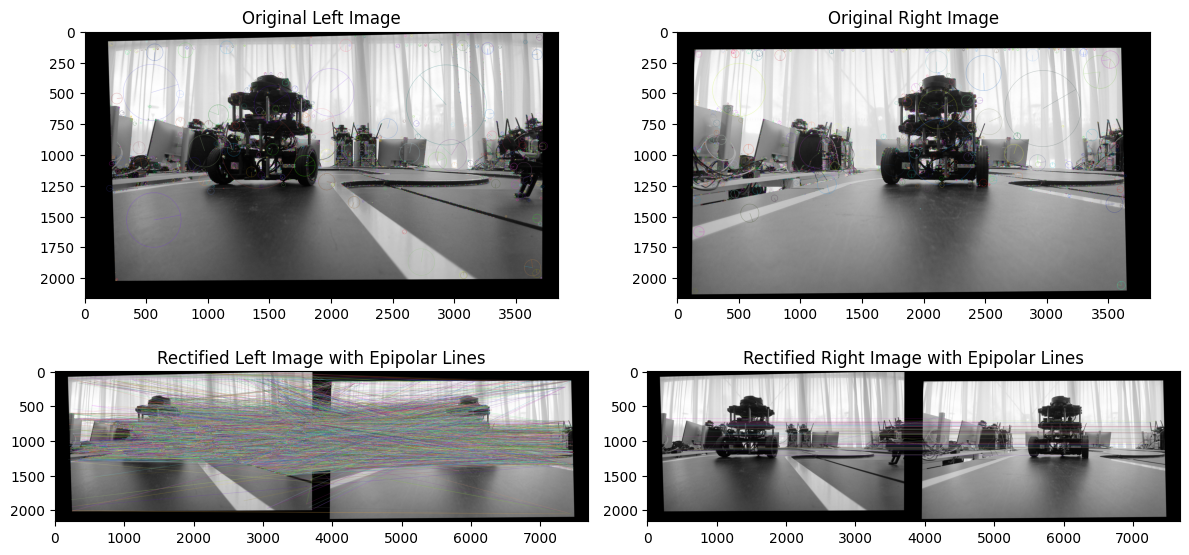

True

In [140]:
imgL_with_kp, imgR_with_kp, img_matches, img_good_matches, pts1, pts2 = feat_detect_match(dataset_name)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Original Left Image")
plt.imshow(imgL_with_kp)

plt.subplot(2, 2, 2)
plt.title("Original Right Image")
plt.imshow(imgR_with_kp)

plt.subplot(2, 2, 3)
plt.title("Rectified Left Image with Epipolar Lines")
plt.imshow(img_matches)

plt.subplot(2, 2, 4)
plt.title("Rectified Right Image with Epipolar Lines")
plt.imshow(img_good_matches)

plt.tight_layout()
plt.show()

# Save the rectified images
cv2.imwrite(os.path.join(dataset_name,"imgL_with_kp.jpg"), imgL_with_kp)
cv2.imwrite(os.path.join(dataset_name,"imgR_with_kp.jpg"), imgR_with_kp)
cv2.imwrite(os.path.join(dataset_name,"img_matches.jpg"), img_matches)
cv2.imwrite(os.path.join(dataset_name,"img_good_matches.jpg"), img_good_matches)

In [131]:
def stereo_geometry_estimation(
    stereo_path, baseline=0.1, cameraMatrix1=None, cameraMatrix2=None
):
    if cameraMatrix1 is None:
        cameraMatrix1 = np.array([[1000, 0, 1920 / 2], [0, 1000, 1080 / 2], [0, 0, 1]])
        print("cameraMatrix1 was not given. Using default cameraMatrix", cameraMatrix1)
    if cameraMatrix2 is None:
        cameraMatrix2 = np.array([[1000, 0, 1920 / 2], [0, 1000, 1080 / 2], [0, 0, 1]])
        print("cameraMatrix2 was not given. Using default cameraMatrix", cameraMatrix2)
        # Default if not provided

    left_image = glob.glob(f"{stereo_path}/left_rectified.jpg")
    right_image = glob.glob(f"{stereo_path}/right_rectified.jpg")

    if not left_image or not right_image:
        return "Error: Missing img1.jpg or img2.jpg in the folder."

    # imgL = cv2.imread(left_image[0], cv2.IMREAD_GRAYSCALE)
    # imgR = cv2.imread(right_image[0], cv2.IMREAD_GRAYSCALE)
    imgL = imgL_rect
    imgR = imgR_rect
    image_dims = imgL.shape

    K0 = np.array(cameraMatrix1)
    K1 = np.array(cameraMatrix2)
    R = np.eye(3)  # Identity matrix (no rotation)
    T = np.array([[baseline], [0], [0]])

    # Use SIFT for feature detection and matching
    sift = cv2.SIFT_create()
    keypoints_left, descriptors_left = sift.detectAndCompute(imgL, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(imgR, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN-based matcher to find correspondences
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Filter matches using the Lowe's ratio test
    pts_left = []
    pts_right = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            pts_left.append(keypoints_left[m.queryIdx].pt)
            pts_right.append(keypoints_right[m.trainIdx].pt)

    pts_left = np.int32(pts_left)
    pts_right = np.int32(pts_right)
    F, mask = cv2.findFundamentalMat(pts_left, pts_right, cv2.FM_LMEDS)

    # Select only inlier points
    pts_left = pts_left[mask.ravel() == 1]
    pts_right = pts_right[mask.ravel() == 1]

    # Compute the Essential Matrix
    E, mask = cv2.findEssentialMat(
        pts_left, pts_right, K0, method=cv2.RANSAC, prob=0.999, threshold=1.0
    )

    # Decompose the Essential Matrix to recover R and T
    _, R, T, _ = cv2.recoverPose(E, pts_left, pts_right, K0)

    return {"essential_matrix": E, "rotation_matrix": R, "translation_vector": T}

In [132]:
stereo_geometry = stereo_geometry_estimation(
    dataset_name,
    baseline=53,
    cameraMatrix1=cameraMatrix,
    cameraMatrix2=cameraMatrix,
)
print(stereo_geometry)

{'essential_matrix': array([[ 2.13873482e-04, -4.79524172e-02,  2.25954324e-02],
       [ 4.06771819e-02, -9.81337690e-04, -7.05575478e-01],
       [-2.22433247e-02,  7.05125744e-01, -7.30823105e-04]]), 'rotation_matrix': array([[ 9.99946275e-01, -4.20476864e-04, -1.03571761e-02],
       [ 4.06335803e-04,  9.99998983e-01, -1.36740593e-03],
       [ 1.03577406e-02,  1.36312398e-03,  9.99945428e-01]]), 'translation_vector': array([[0.99718601],
       [0.03186372],
       [0.06785846]])}


## Triangulation (Sparse Reconstruction)

In [133]:
# Convert points to homogeneous coordinates
points1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
points2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

# Compute the projection matrices for the two cameras
P1 = cameraMatrix @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = cameraMatrix @ np.hstack(
    (R, T)
)  # Projection matrix for the second camera

# Perform triangulation to get 3D points
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

In [134]:
visualize_point_cloud(points_3d)

In [142]:
#Optional: Save the point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.reshape(-1, 3))
o3d.io.write_point_cloud(os.path.join(dataset_name,"point_cloud.ply"), pcd)

True

In [143]:
def visualize_point_cloud(points_3D: np.ndarray, colors: np.ndarray, disparity_map: np.ndarray):
    """Visualizes the 3D point cloud using Open3D.

    This function takes 3D points, colors, and a disparity map, filters out 
    invalid points (NaN, infinite, or where disparity is zero or negative), 
    and visualizes the point cloud using Open3D.

    Args:
        points_3D: 3D point cloud (NumPy array of shape (H, W, 3)).
        colors: Color information for each point (NumPy array of shape (H, W, 3) or (N, 3)).
        disparity_map: Disparity map (NumPy array of shape (H, W)).
    """
    try:
        # Mask invalid points (NaN, infinite, or where disparity is <= 0)
        mask = ~np.isnan(points_3D[:, :, 0]) & ~np.isinf(points_3D[:, :, 0]) & (disparity_map > 0)

        if not np.any(mask): #Check if there are any valid points before proceeding
            print("Warning: No valid points to visualize after masking.")
            return #Exit early if there are no valid points

        valid_points = points_3D[mask]
        valid_colors = colors[mask]


        point_cloud = o3d.geometry.PointCloud()
        point_cloud.points = o3d.utility.Vector3dVector(valid_points) #No need to reshape now
        point_cloud.colors = o3d.utility.Vector3dVector(valid_colors / 255.0)  # Normalize colors

        o3d.visualization.draw_geometries([point_cloud])

    except Exception as e:
        print(f"Error in visualize_point_cloud: {e}")

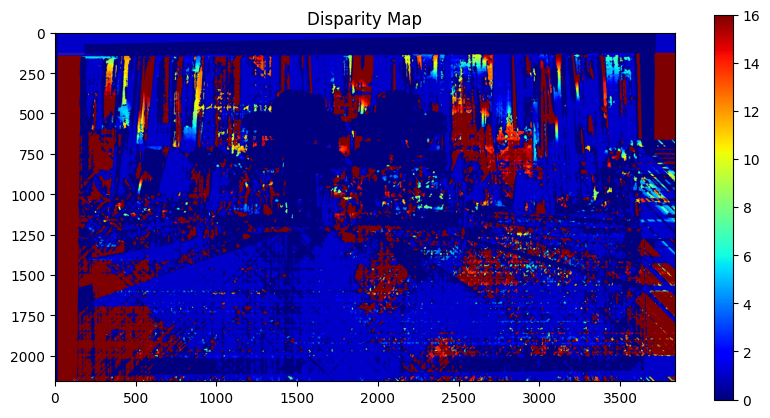

libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


True

In [ ]:
disparity_map=compute_disparity_map(imgL_rect, imgR_rect, 16, 1)
plt.figure(figsize=(10,5))
plt.imshow(disparity_map, cmap='jet')
plt.title("Disparity Map")
plt.colorbar()
plt.show()

# 6. 3D Reconstruction
points_3D = reconstruct_3D(disparity_map, Q)
# 7. Visualization
visualize_point_cloud(points_3D, cv2.cvtColor(imgL_rect_color, cv2.COLOR_BGR2RGB), disparity_map)

#Optional: Save the point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D.reshape(-1, 3))
o3d.io.write_point_cloud(os.path.join(dataset_name,"point_cloud.ply"), pcd)

In [144]:
import open3d as o3d
import numpy as np


def filter_point_cloud(pcd, voxel_size=0.01, nb_neighbors=20, std_ratio=2.0):
    """
    Perform filtering and smoothing on a 3D point cloud.
    Args:
        pcd (o3d.geometry.PointCloud): Input point cloud.
        voxel_size (float): Voxel size for downsampling.
        nb_neighbors (int): Number of neighbors for outlier removal.
        std_ratio (float): Standard deviation ratio for outlier removal.
    Returns:
        o3d.geometry.PointCloud: Processed point cloud.
    """

    # 1. Downsample the point cloud
    print("Downsampling point cloud...")
    pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)

    # 2. Remove statistical outliers
    print("Removing outliers...")
    cl, ind = pcd_down.remove_statistical_outlier(
        nb_neighbors=nb_neighbors, std_ratio=std_ratio
    )
    pcd_filtered = pcd_down.select_by_index(ind)

    # 3. Smoothing using Moving Least Squares (MLS)
    print("Applying smoothing...")
    pcd_smooth = pcd_filtered

    # Pass-through filter to remove distant/close points
    pts = np.asarray(pcd_smooth.points)
    z = pts[:, 2]
    mask = (z > 0.5) & (z < 10.0)  # Adjust based on scene depth
    pcd_filtered = pcd_smooth.select_by_index(np.where(mask)[0])

    # Color points by depth
    z_colors = (z[mask] - z[mask].min()) / (z[mask].max() - z[mask].min())
    pcd_filtered.colors = o3d.utility.Vector3dVector(plt.cm.jet(z_colors)[:, :3])

    return pcd_smooth


# Load the point cloud
pcd = o3d.io.read_point_cloud(os.path.join(dataset_name,"point_cloud.ply"))

# Apply filtering
processed_pcd = filter_point_cloud(pcd)

# Save and visualize
o3d.io.write_point_cloud(os.path.join(dataset_name,"pstprocessed_point_cloud.ply"), processed_pcd)
o3d.visualization.draw_geometries([processed_pcd], window_name="Filtered Point Cloud")

Downsampling point cloud...
Removing outliers...
Applying smoothing...
[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


## Disparity (Dense Recontruction)

In [19]:
def compute_disparity_map(imgL, imgR, ndisp, mindis):
    """
    Compute disparity map from stereo images.

    Parameters:
    - imgL (numpy.ndarray): Left image as a grayscale numpy array.
    - imgR (numpy.ndarray): Right image as a grayscale numpy array.
    - ndisp (int): Upper bound on disparity levels.
    - mindis (int): Minimum disparity value.
    Returns:
    - disparity_map (numpy.ndarray): Disparity map as a float32 numpy array.

    This function uses the StereoSGBM algorithm to compute the disparity map from the left and right images.
    The disparity map is a 2D array where each pixel value represents the disparity between the corresponding points in the left and right images.
    The disparity map is computed using the StereoSGBM algorithm, which is a block-matching algorithm that estimates the disparity by finding the
    best match for each block of pixels in the left image in the right image. The algorithm uses a cost function to measure the similarity between
    the blocks and selects the block with the lowest cost as the best match. The disparity map is then computed by dividing the difference in pixel
    positions between the left and right images by the baseline.

    The function takes as input the left and right images as grayscale numpy arrays, as well as the upper bound on disparity levels (ndisp) and
    the minimum disparity value (mindis). The function returns the disparity map as a float32 numpy array.
    """
    # Using StereoSGBM for better results (more parameters to tune)
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=128,
        blockSize=11,  # You can experiment with this value (odd numbers: 3, 5, 7, ...)
        P1=8 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        P2=32 * 3 * 11**2,  # Adjusted parameters (proportional to blockSize)
        disp12MaxDiff=1,
        preFilterCap=63,  # add this parameter
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
    )

    disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    mask = disparity_map > 0  # Example: keep only positive disparities
    disparity_map = disparity_map * mask.astype(np.float32)
    return disparity_map

In [20]:
def reconstruct_3D(disparity_map: np.ndarray, Q: np.ndarray) -> np.ndarray:
    """Reconstructs 3D points from a disparity map using a Q matrix.

    This function takes a disparity map and a Q (disparity-to-depth) matrix 
    and uses OpenCV's `cv2.reprojectImageTo3D` to reconstruct a 3D point cloud.

    Args:
        disparity_map: The disparity map (NumPy array, usually float32).
        Q: The disparity-to-depth mapping matrix (4x4 NumPy array).

    Returns:
        A 3D point cloud (NumPy array).  The shape of the returned array 
        is (height, width, 3), where each element [y, x, :] represents the 
        3D coordinates (x, y, z) of the point corresponding to pixel (x, y) 
        in the disparity map.  Returns None if there is an error.
    """
    try:
        points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
        return points_3D
    except Exception as e:
        print(f"Error in reconstruct_3D: {e}")
        return None

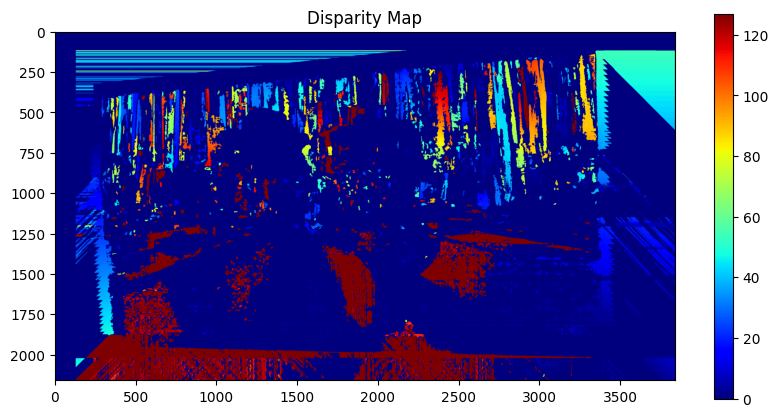

TypeError: visualize_point_cloud() takes 1 positional argument but 3 were given

In [21]:
disparity_map = compute_disparity_map(imgL_rect, imgR_rect, 16, 0)

plt.figure(figsize=(10,5))
plt.imshow(disparity_map, cmap='jet')
plt.title("Disparity Map")
plt.colorbar()
plt.show()

# 6. 3D Reconstruction
points_3D = reconstruct_3D(disparity_map, Q)
# 7. Visualization
visualize_point_cloud(points_3D, cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB), disparity_map)

#Optional: Save the point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D.reshape(-1, 3))
o3d.io.write_point_cloud(f"{dataset_name}_point_cloud.ply", pcd)

In [145]:
import cv2
import numpy as np

img1 = cv2.imread(os.path.join(dataset_name,"left_rectified.jpg"))
img2 = cv2.imread(os.path.join(dataset_name,"right_rectified.jpg"))
K = K0
# find the keypoints and descriptors with SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

In [146]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

# Find point matches
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
# Apply Lowe's SIFT matching ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

In [147]:
# pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
# pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

# Constrain matches to fit homography
retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
mask = mask.ravel()

# We select only inlier points
pts1 = src_pts[mask == 1]
pts2 = dst_pts[mask == 1]

E, mask = cv2.findEssentialMat(
    pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
)

_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)
R, t

(array([[ 9.99862253e-01,  1.01868057e-03, -1.65661558e-02],
        [-9.55422050e-04,  9.99992224e-01,  3.82600572e-03],
        [ 1.65699245e-02, -3.80965103e-03,  9.99855452e-01]]),
 array([[ 0.99842267],
        [-0.05591872],
        [ 0.00502629]]))

In [149]:
# Build the projection matrices for the two cameras
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = np.hstack((R, t))

# Convert the projection matrices to the camera coordinate system
P1 = K @ P1
P2 = K @ P2

# Triangulate the 3D points
points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
points_3D = points_4D / points_4D[3]  # Convert from homogeneous to Cartesian coordinates
points_3D = points_3D[:3, :].T

error: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/triangulate.cpp:75: error: (-209:Sizes of input arguments do not match) Number of proj points coordinates must be == 2 in function 'icvTriangulatePoints'


NameError: name 'points_3D' is not defined

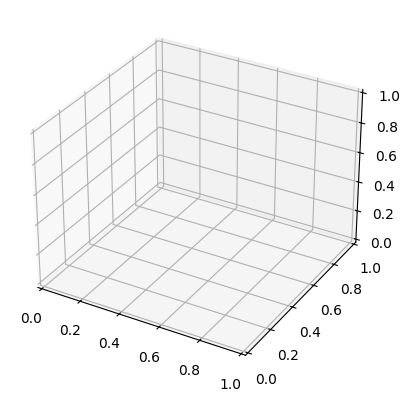

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='r', alpha=0.5)

# Configure the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Total matches found: 1957
Total strong matches after filtering: 9


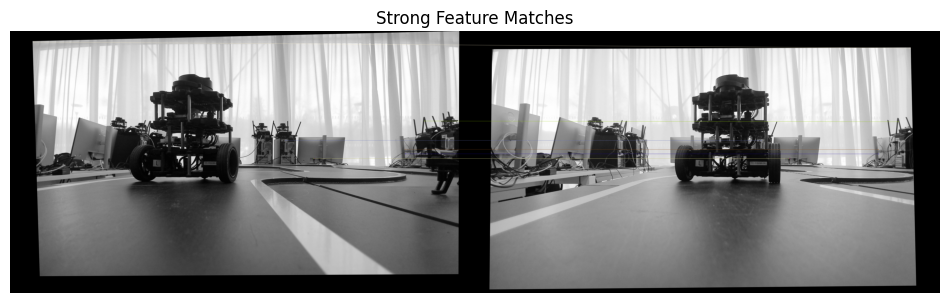

Essential Matrix:
[[ -0.52254083  -4.40998964  -2.94396499]
 [  6.14677713   4.12704784  12.77572179]
 [  3.37747299 -12.99750867   0.03291666]]
Possible Rotation Matrices:
[[ 0.97498539  0.05022968 -0.21651896]
 [-0.08502554  0.98432436 -0.15451932]
 [ 0.20536343  0.16906372  0.96397267]]
[[ 0.62755454  0.36390753 -0.68829253]
 [ 0.45540369 -0.88860919 -0.05460021]
 [-0.6314925  -0.27918635 -0.72337557]]
Translation Vector:
[ 0.94317651  0.21798644 -0.25079869]


In [150]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



rectified_img1 = cv2.imread(os.path.join(dataset_name,"left_rectified.jpg"))
rectified_img2 = cv2.imread(os.path.join(dataset_name,"right_rectified.jpg"))

# Feature Detection and Matching using SIFT

# surf = cv2.SURF_create()  # Updated SURF implementation
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

akaze = cv2.AKAZE_create()
bf_akaze = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# sift = cv2.SIFT_create()
# flann = cv2.FlannBasedMatcher()

# orb = cv2.ORB_create()
# bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Detect keypoints and descriptors in both images
kp1, des1 = akaze.detectAndCompute(rectified_img1, None)
kp2, des2 = akaze.detectAndCompute(rectified_img2, None)

# Match features using FLANN-based matcher
matches = bf_akaze.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)  # Sort matches by distance

# Set a threshold to filter out weak matches
# This threshold can be adjusted based on your needs
threshold = 20 # Matches with distance < 50 are considered strong
good_matches = [m for m in matches if m.distance < threshold]

# Print number of good matches
print(f"Total matches found: {len(matches)}")
print(f"Total strong matches after filtering: {len(good_matches)}")

# Extract the matched keypoints for the good matches
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Use RANSAC to compute the Fundamental Matrix and filter out outliers
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=3)

# Select inliers (good matches after RANSAC)
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]


# Visualize the matched features after filtering with RANSAC
matched_img = cv2.drawMatches(rectified_img1, kp1, rectified_img2, kp2, good_matches, None, 
                              matchesMask=mask.ravel().tolist(), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title("Strong Feature Matches")
plt.axis("off")
plt.show()

# # Save the matched features image
cv2.imwrite("strong_feature_matches_with_ransac.jpg", matched_img)

# Compute Essential Matrix
E = cameraMatrix.T @ F @ cameraMatrix
print("Essential Matrix:")
print(E)

# Decompose Essential Matrix to get Rotation and Translation
U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# Possible solutions
R1 = U @ W @ Vt
R2 = U @ W.T @ Vt
t = U[:, 2]

print("Possible Rotation Matrices:")
print(R1)
print(R2)
print("Translation Vector:")
print(t)

In [151]:
import open3d as o3d

# Load your point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)  # Convert numpy to Open3D format

# Apply statistical outlier removal
pcd_filtered, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# Visualize before and after
o3d.visualization.draw_geometries([pcd], window_name="Noisy Point Cloud")
o3d.visualization.draw_geometries([pcd_filtered], window_name="Filtered Point Cloud")
o3d.io.write_point_cloud(os.path.join(dataset_name,"point_cloud.ply"), pcd_filtered)


[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /home/rafay/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
libGL error: MESA-LOADER: failed to open radeon

True